In [48]:
# conda activate aso_design
import sys
from pathlib import Path

p = Path.cwd()
while p != p.parent and not (p / "pyproject.toml").exists():
    p = p.parent

sys.path.insert(0, str(p))
print("Project root:", p)



import pandas as pd
from notebooks.consts import *
from tauso.file_utils import read_human_genome_fasta_dict
from tauso.consts import *
import numpy as np
from tauso.util import get_antisense
import pickle
from tauso.genome.read_human_genome import get_locus_to_data_dict
from tauso.file_utils import read_human_genome_fasta_dict
import RNA

Project root: /home/nivd1/TAUSO


In [49]:
csv_path = NOTEBOOK_PATH / 'data' / 'data_asoptimizer_updated.csv'
all_data = pd.read_csv(str(csv_path), low_memory=False)

Preprocessing ASO Experimental Dataset

In [50]:
from notebooks.notebook_utils import log_correction

# Remove rows with missing values in the INHIBITION column
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
# Create a new column with transformed inhibition values on a negative log scale
log_correction(all_data_no_nan) # to avoid log 0

In [51]:
# Filter the data to include only rows where the cell line organism is human
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
# Remove non-human or negative controls from the gene list
genes_u.remove('HBV')
genes_u.remove('negative_control')

In [52]:
from notebooks.notebook_utils import read_cached_gene_to_data

gene_to_data = read_cached_gene_to_data(genes_u)

In [53]:
# Filter data to keep only rows with valid gene information
all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()

# Define names for new columns
SENSE_SEQUENCE = 'sense_sequence'
PRE_MRNA_SEQUENCE = 'pre_mrna_sequence'
SENSE_START = 'sense_start'
SENSE_LENGTH = 'sense_length'

# Initialize new columns
all_data_human_gene[SENSE_SEQUENCE] = ""
all_data_human_gene[PRE_MRNA_SEQUENCE] = ""
all_data_human_gene[SENSE_START] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)
all_data_human_gene[SENSE_LENGTH] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)

# Iterate over each row and compute the antisense complement and the gene's pre-mRNA
for index, row in all_data_human_gene.iterrows():
    gene_name = row[CANONICAL_GENE]

    if gene_name not in gene_to_data:
        continue  # Skip genes not found in genome annotation

    locus_info = gene_to_data[gene_name]
    pre_mrna = locus_info.full_mrna
    antisense = row[SEQUENCE]
    sense = get_antisense(antisense)
    idx = pre_mrna.find(sense)

    # Store computed sequences in new columns
    all_data_human_gene.loc[index, SENSE_START] = idx
    all_data_human_gene.loc[index, SENSE_LENGTH] = len(antisense)
    all_data_human_gene.at[index, SENSE_SEQUENCE] = sense
    all_data_human_gene.at[index, PRE_MRNA_SEQUENCE] = pre_mrna

In [54]:
all_data_human_gene.columns

Index(['index', 'ISIS', 'Target_gene', 'Cell_line', 'Density(cells/well)',
       'Transfection', 'ASO_volume(nM)', 'Treatment_Period(hours)',
       'Primer_probe_set', 'Sequence', 'Modification', 'Location',
       'Chemical_Pattern', 'Linkage', 'Linkage_Location', 'Smiles',
       'Inhibition(%)', 'seq_length', 'Canonical Gene Name',
       'Cell line organism', 'Transcript', 'Location_in_sequence',
       'Location_div_by_length', 'true_length_of_seq', 'mod_scan',
       'cell_line_uniform', 'log_inhibition', 'sense_sequence',
       'pre_mrna_sequence', 'sense_start', 'sense_length'],
      dtype='object')

Generate features

In [55]:
# purine content
from src.tauso.features.seq_features import purine_content
from Bio.Seq import Seq

all_data_human_gene['ASO_purine_content'] = all_data_human_gene["Sequence"].apply(lambda x: purine_content(x))
sequence_features = ['ASO_purine_content']

In [56]:
from Bio.SeqUtils import gc_fraction

all_data_human_gene['ASO_gc_content'] = all_data_human_gene["Sequence"].apply(gc_fraction)
sequence_features.append('ASO_gc_content')


In [57]:
# count_g_runs
from src.tauso.features.seq_features import count_g_runs
all_data_human_gene['ASO_ggg_counts'] = all_data_human_gene["Sequence"].apply(lambda x: count_g_runs(x))
sequence_features.append("ASO_ggg_counts")

In [58]:
#ENC
from src.tauso.features.seq_features import compute_ENC
all_data_human_gene["ASO_ENC"] = all_data_human_gene["Sequence"].apply(lambda x: compute_ENC(x))
sequence_features.append("ASO_ENC")

In [59]:
# palindromic count of 4 and 6 palindroms
from src.tauso.features.seq_features import palindromic_fraction
all_data_human_gene['ASO_4 palindromic'] = all_data_human_gene[SEQUENCE].apply(lambda x: palindromic_fraction(x,4))
sequence_features.append("ASO_4 palindromic")

all_data_human_gene['ASO_6 palindromic'] = all_data_human_gene[SEQUENCE].apply(lambda x: palindromic_fraction(x,6))
sequence_features.append("ASO_6 palindromic")

In [60]:
# entropy
from src.tauso.features.seq_features import seq_entropy
all_data_human_gene["ASO_entropy"] = all_data_human_gene["Sequence"].apply(lambda x: seq_entropy(x))
sequence_features.append("ASO_entropy")

In [61]:
#hairpin_score
from src.tauso.features.seq_features import hairpin_score
all_data_human_gene["ASO_hairpin_score"] = all_data_human_gene["Sequence"].apply(lambda x : hairpin_score(x))
sequence_features.append("ASO_hairpin_score")

In [62]:
#toxic_motif_count
from src.tauso.features.seq_features import toxic_motif_count
all_data_human_gene["ASO_toxic_motif_count"] = all_data_human_gene["Sequence"].apply(lambda x : toxic_motif_count(x))
sequence_features.append("ASO_toxic_motif_count")

In [63]:
# hairpin_dG_energy
from src.tauso.features.seq_features import hairpin_dG_energy
all_data_human_gene["ASO_hairpin_dG_energy"] = all_data_human_gene["Sequence"].apply(lambda x : hairpin_dG_energy(x))
sequence_features.append("ASO_hairpin_dG_energy")

In [64]:
#hairpin_tm
from src.tauso.features.seq_features import hairpin_tm
all_data_human_gene["ASO_hairpin_tm"] = all_data_human_gene["Sequence"].apply(lambda x : hairpin_tm(x))
sequence_features.append("ASO_hairpin_tm")


In [65]:
#tandem_repeats_score
from src.tauso.features.seq_features import tandem_repeats_score
all_data_human_gene["ASO_tandem_repeats_score"] = all_data_human_gene["Sequence"].apply(lambda x : tandem_repeats_score(x))
sequence_features.append("ASO_tandem_repeats_score")

In [66]:
# dispersed_repeats_score
from src.tauso.features.seq_features import dispersed_repeats_score
all_data_human_gene["ASO_dispersed_repeats_score"] = all_data_human_gene["Sequence"].apply(lambda x : dispersed_repeats_score(x))
sequence_features.append("ASO_dispersed_repeats_score")


In [67]:
#flexible_dinucleotide_fraction
from src.tauso.features.seq_features import flexible_dinucleotide_fraction
all_data_human_gene["ASO_flexible_dinucleotide_fraction"] = all_data_human_gene["Sequence"].apply(lambda x : flexible_dinucleotide_fraction(x))
sequence_features.append("ASO_flexible_dinucleotide_fraction")

In [68]:
#gc_skew
from src.tauso.features.seq_features import gc_skew
all_data_human_gene["ASO_gc_skew"] = all_data_human_gene["Sequence"].apply(lambda x : gc_skew(x))
sequence_features.append("ASO_gc_skew")

In [69]:
#gc_skew_ends
from src.tauso.features.seq_features import gc_skew_ends
all_data_human_gene["ASO_gc_skew_ends"] = all_data_human_gene["Sequence"].apply(lambda x : gc_skew_ends(x))
sequence_features.append("ASO_gc_skew_ends")

In [70]:
#at_skew
from src.tauso.features.seq_features import at_skew
all_data_human_gene["ASO_at_skew"] = all_data_human_gene["Sequence"].apply(lambda x : at_skew(x))
sequence_features.append("ASO_at_skew")

In [71]:
#stop_codon_count
from src.tauso.features.seq_features import stop_codon_count
all_data_human_gene["ASO_stop_codon_count"] = all_data_human_gene["Sequence"].apply(lambda x : stop_codon_count(x))
sequence_features.append("ASO_stop_codon_count")

In [72]:
#nucleotide_diversity
from src.tauso.features.seq_features import nucleotide_diversity
all_data_human_gene["ASO_nucleotide_diversity"] = all_data_human_gene["Sequence"].apply(lambda x : nucleotide_diversity(x))
sequence_features.append("ASO_nucleotide_diversity")

In [73]:
#cg_dinucleotide_fraction
import importlib
#import niv_features
#importlib.reload(niv_features)
from src.tauso.features.seq_features import cg_dinucleotide_fraction
all_data_human_gene["ASO_cg_dinucleotide_fraction"] = all_data_human_gene["Sequence"].apply(lambda x : cg_dinucleotide_fraction(x))
sequence_features.append("ASO_cg_dinucleotide_fraction")

In [74]:
#poly_pyrimidine_stretch
from src.tauso.features.seq_features import poly_pyrimidine_stretch
all_data_human_gene["ASO_poly_pyrimidine_stretch"] = all_data_human_gene["Sequence"].apply(lambda x : poly_pyrimidine_stretch(x))
sequence_features.append("ASO_poly_pyrimidine_stretch")

In [75]:
#dinucleotide_entropy
from src.tauso.features.seq_features import dinucleotide_entropy
all_data_human_gene["ASO_dinucleotide_entropy"] = all_data_human_gene["Sequence"].apply(lambda x : dinucleotide_entropy(x))
sequence_features.append("ASO_dinucleotide_entropy")

In [76]:
#gc_block_length
from src.tauso.features.seq_features import gc_block_length
all_data_human_gene["ASO_gc_block_length"] = all_data_human_gene["Sequence"].apply(lambda x : gc_block_length(x))
sequence_features.append("ASO_gc_block_length")

In [77]:
#at_rich_region_score
from src.tauso.features.seq_features import at_rich_region_score
all_data_human_gene["ASO_at_rich_region_score"] = all_data_human_gene["Sequence"].apply(lambda x : at_rich_region_score(x))
sequence_features.append("ASO_at_rich_region_score")

In [78]:
from src.tauso.features.tai import calc_tAI, tai_weights
weights_tai = tai_weights("hm")
all_data_human_gene["ASO_tai"] = all_data_human_gene["Sequence"].apply(lambda x : calc_tAI(x, weights_tai))
sequence_features.append("ASO_tai")

In [79]:
from src.tauso.features.seq_features import gc_content_3prime_end
all_data_human_gene["ASO_gc_content_3prime_end"] = all_data_human_gene["Sequence"].apply(lambda x : gc_content_3prime_end(x))
sequence_features.append("ASO_gc_content_3prime_end")

In [80]:
from src.tauso.features.seq_features import homooligo_count
all_data_human_gene["ASO_homooligo_count"] = all_data_human_gene["Sequence"].apply(lambda x : homooligo_count(x))
sequence_features.append("ASO_homooligo_count")

In [81]:
from notebooks.features.RNaseH.correlation_test import plot_feature_correlations_by_prefix  
from notebooks.features.RNaseH.correlation_test import analyze_feature_correlations
results_df = analyze_feature_correlations(all_data_human_gene, target='log_inhibition')
display(results_df)

,Feature,Pearson,Spearman,NMI_max
16,Inhibition(%),0.891,1.000,2.058
1,ISIS,-0.092,-0.145,0.154
0,index,0.317,0.301,0.113
28,sense_start,-0.018,0.219,0.108
21,Location_in_sequence,-0.013,0.223,0.107
6,ASO_volume(nM),0.288,0.296,0.090
22,Location_div_by_length,0.084,0.129,0.045
54,ASO_tai,-0.144,-0.139,0.040
7,Treatment_Period(hours),-0.132,-0.266,0.031
36,ASO_entropy,0.015,0.019,0.030


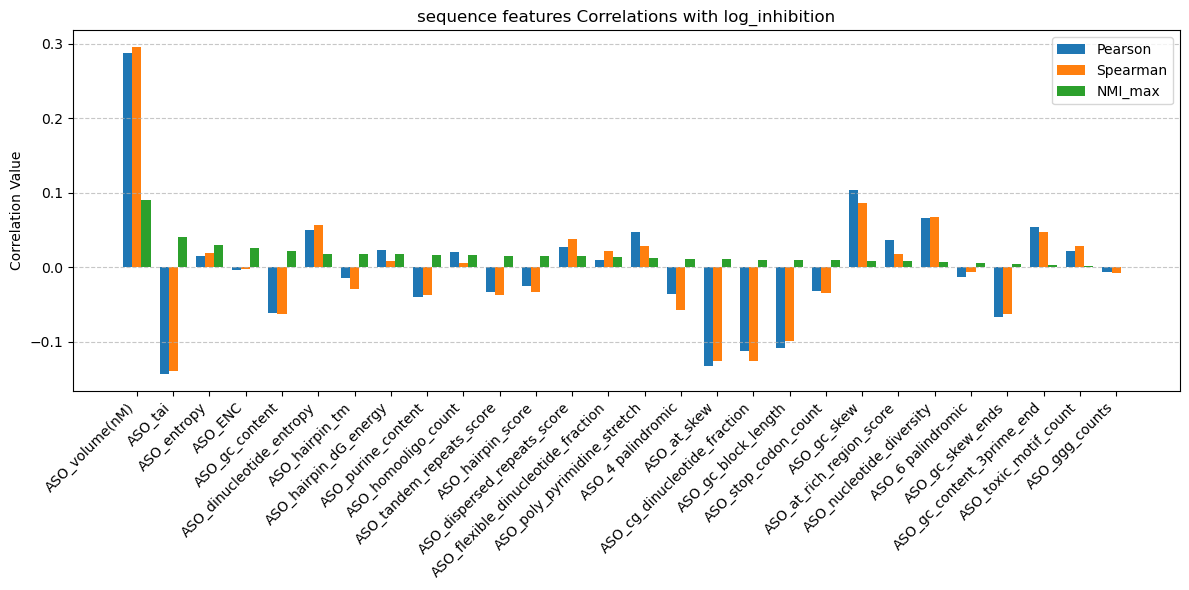

In [82]:
from notebooks.features.RNaseH.correlation_test import plot_feature_correlations_by_prefix
plot_feature_correlations_by_prefix(results_df, prefix='ASO_', title='sequence features Correlations with log_inhibition')

In [83]:
from notebooks.features.feature_extraction import save_feature
for feature in sequence_features:
    save_feature(all_data_human_gene, feature_name=feature)